# Probabilistic Initiation Set Classifier

## Imports

In [176]:
from sklearn import svm, datasets
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegressionCV as LRCV
from scipy.stats import kde

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import numpy as np
from random import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(color_codes=True)
sns.set_style("white")
%matplotlib inline

## Utilities

In [187]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def create_plots(models, titles, X, y, grid):
    """Creates plots of models.
    
        Parameters
        ----------
        models : tuple of models
        titles : tuple of title names
        X : input
        y: class labels
        grid : tuple of grid size 
    """
    
    # Set-up grids for plotting.
    fig, sub = plt.subplots(grid[0], grid[1])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_contours(ax, clf, xx, yy,
                      cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
#         ax.set_xlabel('x')
#         ax.set_ylabel('y')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

In [137]:
def plot_state_probs(X, clf, nbins, option_id, name, color):    
    
    x, y = X[:,0], X[:,1]
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    
    xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
    
    probs = clf.predict_proba(np.vstack([xi.flatten(), yi.flatten()]).T)[:,1]
    
    fig, ax = plt.subplots()
    ax.set_title('(Option {}) Probability of states ({})'.format(option_id, name))

    cmap = sns.light_palette(color, n_colors=nbins, as_cmap=True)

    states = ax.pcolormesh(xi, yi, probs.reshape(xi.shape), shading='gouraud', cmap=cmap)
    cbar = fig.colorbar(states)
    
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()

In [ ]:
def plot_prob(tcsvm_dfs, ocsvm_dfs, title, episode, test_name):
    N = len(tcsvm_dfs)

    for i in range(N):
                
        color = sns.hls_palette(N)[i]
        
        tcsvm_df, ocsvm_df = tcsvm_dfs[i], ocsvm_dfs[i]
        plt.plot(tcsvm_df["prob"], c=color, label="{} - tcsvm".format(i))
        plt.plot(ocsvm_df["prob"], c=color, label="{} - ocsvm".format(i), linestyle='--')  

    plt.title("(Episode {}) {}".format(episode, title))
    plt.ylabel("Probabilities")
    plt.xlabel("Occurances")
    plt.legend(title="Options", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
    plt.show()

## Classification

In [105]:
def opt_clf(X_, y_):
    '''
    Optimistic classifier that is two-class SVM 
    
    Args:
        X_: Input data
        y_: Input labels
    
    Returns:
        Fitted two-class linear classifier
    '''
    tcsvm = svm.SVC(gamma='scale', probability=True)
    
    return tcsvm.fit(X_,y_)

def pes_clf(tcsvm_, X_, y_):
    '''
    Pessimistic classifier that is a one-class SVM
    
    Args:
    
    Returns:
    
    '''
    # Get subset of inputs that are on the (+) side of the optimistic classifier
    y_pred = tcsvm_.predict(X_)
    X_pos = X_[y_pred == 1]
    y_pos = [1] * X_pos.shape[0]
    
    # Fit one-class SVM (non-linear) from (+) subset of inputs from two-class SVM
    ocsvm = svm.OneClassSVM(kernel="rbf", nu=0.1, gamma="scale")
    
    return ocsvm.fit(X_pos, y_pos)

In [106]:
def platt_scale(ocsvm_, X_, train_size, cv_size):
    """
    Uses Platt Scalling to get probability values from one-class SVM
    
    Args:
        clf: OneClassSVM classifier (post-fit on TCSVM (+) data)
        X_data: data that clf was fitted on
        y_labels: labels that cls was fitted on 
    
    Returns:
        
    """
    
    # 1. Get SVM predictions
    y_SVM_pred = ocsvm_.predict(X_)

    # 2. Split the data and SVM labels
    X_train, X_test, y_train, y_test = train_test_split(X_, y_SVM_pred, train_size=train_size)

    # 3. Train using logistic regression layer with cross validation 
    lr = LRCV(cv=cv_size)
#     lr.fit(X_train, y_train)
    lr.fit(X, y)
    # 4. Return prediction probabilities on test data    
    return lr, lr.predict_proba(X_test)

## Plotting

In [107]:
X, y = datasets.make_classification(n_samples=1000, n_features=2,
                                    n_informative=2, n_redundant=0)
# Call classifiers
tcsvm = opt_clf(X, y)
ocsvm = pes_clf(tcsvm, X, y)
psmod, _ = platt_scale(ocsvm, X, 0.90, 5)

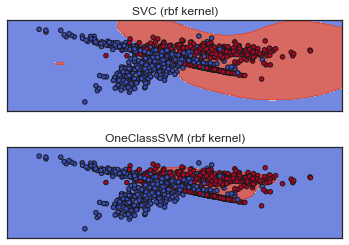

In [138]:
# Plot two classifiers
models = (tcsvm, ocsvm)
titles = ('SVC (rbf kernel)', 'OneClassSVM (rbf kernel)')
create_plots(models, titles, X, y, grid=(2,1))

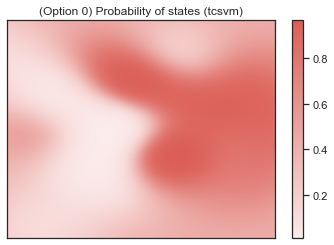

In [139]:
# Plot classifiers
color = sns.hls_palette(2)[0]
nbins = 100

plot_state_probs(X, tcsvm, nbins, 0, "tcsvm", color)

In [119]:
# Probability data format
col = ["x", "y", "prob"]

# TCSVM data
opt1_tcsvm_prob = [[0,0,0.9],
                   [1,0,0.7],
                   [2,0,0.6],
                   [3,0,0.4]]
opt2_tcsvm_prob = [[3,1,0.9],
                   [3,2,0.8],
                   [3,3,0.7],
                   [3,4,0.6]]
opt3_tcsvm_prob = [[2,4,0.9],
                   [1,4,0.8],
                   [0,4,0.7]]
df1 = pd.DataFrame(opt1_tcsvm_prob, columns=col)
df2 = pd.DataFrame(opt2_tcsvm_prob, columns=col)
df3 = pd.DataFrame(opt3_tcsvm_prob, columns=col)
tcsvm_dfs = {0:df1, 1:df2, 2:df3}

# OCSVM data
opt1_ocsvm_prob = [[0,0,0.6],
                   [1,0,0.7],
                   [2,0,0.8],
                   [3,0,0.9]]
opt2_ocsvm_prob = [[3,1,0.6],
                   [3,2,0.7],
                   [3,3,0.8],
                   [3,4,0.9]]
opt3_ocsvm_prob = [[2,4,0.7],
                   [1,4,0.8],
                   [0,4,0.9]]
df1 = pd.DataFrame(opt1_ocsvm_prob, columns=col)
df2 = pd.DataFrame(opt2_ocsvm_prob, columns=col)
df3 = pd.DataFrame(opt3_ocsvm_prob, columns=col)
ocsvm_dfs = {0:df1, 1:df2, 2:df3}

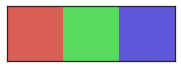

In [121]:
sns.palplot(sns.hls_palette(len(tcsvm_dfs)))

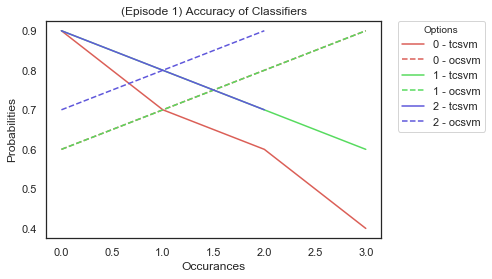

In [123]:
# Test call
plot_prob(tcsvm_dfs, ocsvm_dfs, "Accuracy of Classifiers", 1, "test")

In [185]:
def plot_boundary(X, clf, color, option_id, clf_name):
    x, y = X[:,0], X[:,1]
    x_mesh, y_mesh = make_meshgrid(x, y)

    z = clf.predict(np.c_[x_mesh.ravel(), y_mesh.ravel()])
    z = z.reshape(x_mesh.shape)

    # Color mapping of white and option color
    colors = [(1, 1, 1), color]
    cmap = ListedColormap(colors)

    plt.contourf(x_mesh, y_mesh, z, cmap=cmap, alpha=0.8)
    plt.xticks(())
    plt.yticks(())
    plt.title("Option {} - {}".format(option_id, clf_name))
    plt.show()


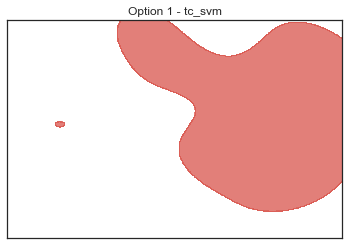

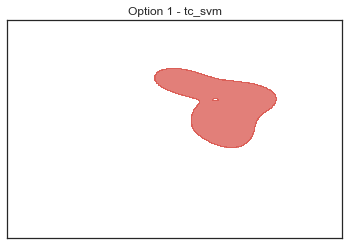

In [188]:
# Test call
color = sns.hls_palette(1)[0]
plot_boundary(X, tcsvm, color, 1, 'tc_svm')
plot_boundary(X, ocsvm, color, 1, 'tc_svm')


In [198]:
test = [[1,2], [3,4]]



test = [np.array(row) for row in test]
test = np.array(test)
test[0]

array([1, 2])

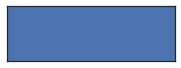

In [202]:
sns.palplot(sns.color_palette()[0])

In [1]:
if "goal" in "goal_overall_policy":
    print("YES!")

YES?
